# antBot Highway World Experiments
Including multiple datasets, experiment classes, etc.

In [1]:
from os import listdir
import numpy as np
import pandas as pd
import matplotlib.pyplot as P
import seaborn as sns
from tqdm.notebook import trange, tqdm
from pyRC.analyse.perfectMemory import *

# Plotting settings
sns.set_context("notebook", font_scale = 1.5)
sns.set_style("dark")
sns.set_palette("deep", 12)
from ipywidgets import interact, interactive, fixed, interact_manual
cmap='Greys_r'

## Experiment Class

In [2]:
ACCIDF     = lambda df, tol: np.mean(abs(df['imageID']-df['predIDF'])<tol)*100
ACCCORCOEF = lambda df, tol: np.mean(abs(df['imageID']-df['predCORCOEF'])<tol)*100

ERRIDF     = lambda df: np.mean(abs(df['imageID']-df['predIDF']))
ERRCORCOEF = lambda df: np.mean(abs(df['imageID']-df['predCORCOEF']))

In [3]:
class antBotExp():
    #TODO: move into analyse?
    #TODO: add docstrings
    #TODO: pixel-normalisation
    #TODO: improve naming
    def __init__(self, expPath, dataSets):
        self.expPath     = expPath # experiment path
#         self.strImages   = sorted([f.replace('.npy','') for f in listdir(self.expPath)])# get the name of all data in the given experiment path
        self.strImages   = dataSets
        self.allImages   = np.stack([np.load(self.expPath+f+'.npy') for f in self.strImages])# load all the data matched in strImages 
        self.nDatasets   = self.allImages.shape[0]
        self.nImages     = self.allImages.shape[1]
        self.HW_Original = self.allImages.shape[-2:]
        print(f'>> Loaded {self.nDatasets} datasets of {self.nImages} images each!')
                
    def mask(df, key, value):
        return df[df[key] == value]
    pd.DataFrame.mask = mask
    
    def setGT(self, strGT):
        # Set GT from a list: multiple images can exist in database!
        #TODO try except error throw if strGT is not in list
        self.strGT    = strGT # ground truth name
        self.gtImages = self.allImages[self.strImages.index(strGT)] # find the index of the gtName in the list of names first
        print(f'>> Set `{self.strGT}` as ground truth!')
    
    def loadResultsDF(self, fileName):
        self.dfR = pd.read_pickle(fileName + ".pkl")
        return self.dfR
        
    def getResultsDF(self, hw, fileName=None):
        #TODO try except error throw setGT() first
        pbar = tqdm()
        pbar.reset(total= self.nDatasets * self.nImages) # total is nDatasets x nImages x nCamSize
        results = []
        for dsID in range(self.nDatasets):     # loop through all datasets
            for ID in range(self.nImages): # loop through all images 
                pbar.update()
                img = self.allImages[dsID][ID]
                results.append([self.expPath.split('/')[-2], self.strGT, self.strImages[dsID], str(hw), ID, findIDF(self.gtImages, img, *hw), findCORCOEF(self.gtImages, img, *hw)]) # search in ground truth
        pbar.refresh()  # force print final status but don't `close()`
        self.dfR = pd.DataFrame(results, columns=["expName", "dataSetGT", "dataSet", "camSize", "imageID", "predIDF", "predCORCOEF"])
        if fileName:
            self.dfR.to_pickle(fileName + ".pkl")
        return self.dfR
    
    def getScoresDF(self, hw, tol = 5):
        #TODO try except error throw run getResultsDF() first
        scores = []
        for strImg in self.strImages: # loop through all datasets
            df_ = self.dfR.mask('dataSet',strImg).mask('camSize',str(hw))
            scores.append([self.expPath.split('/')[-2], self.strGT, strImg, str(hw), ACCIDF(df_,tol), ACCCORCOEF(df_,tol), ERRIDF(df_), ERRCORCOEF(df_)])
        self.dfS = pd.DataFrame(scores, columns=["expName", "dataSetGT", "dataSet","camSize", "accIDF", "accCORCOEF", "errIDF", "errCORCOEF"])
        return self.dfS
    
    def getResultDF(self, strDataset, hw):
        #TODO try except error throw setGT() first
        results = []
        dsID    = self.strImages.index(strDataset)
        for ID in range(self.nImages): # loop through all images 
            img = self.allImages[dsID][ID]
            results.append([self.expPath.split('/')[-2], self.strGT, self.strImages[dsID], str(hw), ID, findIDF(self.gtImages, img, *hw), findCORCOEF(self.gtImages, img, *hw)]) # search in ground truth
        dfR = pd.DataFrame(results, columns=["expName", "dataSetGT", "dataSet", "camSize", "imageID", "predIDF", "predCORCOEF"])
        return dfR
    
    def plot(self, dfS, yValues = 'accCORCOEF', fileName=None):
        #TODO try except error throw getScoresDF() first
        fig, ax = P.subplots(figsize=(16,9))
        plt = sns.barplot(data=dfS, x='dataSet', y=yValues, hue='camSize')
        ax.set_xticklabels(ax.get_xticklabels(),rotation=70);
        ax.set_title(f'Ground Truth: {self.strGT}')
        if fileName:
            P.savefig('./figs/' + fileName)
        else:
            P.show()

# Experiment 1: Find Label
Given image `img`, find in set of images `Images`.

In [4]:
HW       = [[75,360], [50,180], [25,90]] # (h,w) pairs FIXED for now
expPath  = '../data/2000-10/'
# dataSets = sorted([f.replace('.npy','') for f in listdir(expPath)])# get the name of all data in the given experiment path
dataSets = ['mountains', 'dusk', 'dawn_cloudy_empty']
exp = antBotExp(expPath = expPath, dataSets=dataSets)
exp.setGT('mountains')

>> Loaded 3 datasets of 200 images each!
>> Set `mountains` as ground truth!


In [5]:
listDFR = []
listDFS = []
for hw in HW:
    listDFR.append(exp.getResultsDF(hw, fileName = './data/gt-'+ exp.strGT))
    listDFS.append(exp.getScoresDF(hw, tol = 5)) # not sure how stable, check

In [6]:
DFR = pd.concat(listDFR)
DFS = pd.concat(listDFS)

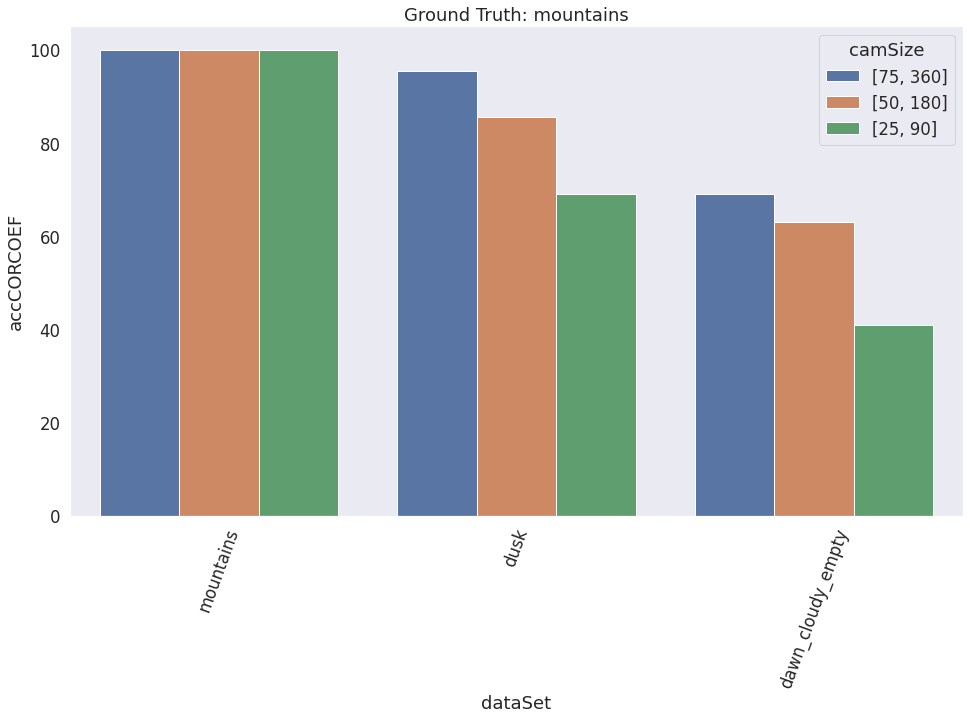

In [8]:
exp.plot(DFS, 'accCORCOEF')